<a href="https://colab.research.google.com/github/tarslan/data/blob/master/csce896_assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 01: Deep Study of Fully-Connected Feedforward Deep Neural Network
The goal of this assignment is to investigate the role of three factors in training fully-connected feedforward Deep Neural Networks(DNNs) optimally. This type of networks is known as Dense networks as well.
- Weight Initializer
- Activation Function
- Learning rate Optimizer for SGD)

## Import Necessary Packages

In [ ]:
# Import librairies
import tensorflow as tf
import random
import timeit
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import keras.backend as K


## Load the Cifar10 Dataset

In [ ]:
# Load CIFAR10 dataset
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Randomly select n samples from training set as validation set and normalize data
n_samples = 5000
randomList = np.array(random.sample(range(X_train_full.shape[0]), n_samples))
X_val = X_train_full[randomList]/255.
y_val = y_train_full[randomList]

# Define  and scale the training set
X_train = np.delete(X_train_full, randomList, axis=0)/255.
y_train = np.delete(y_train_full, randomList, axis=0)

# Scale test set
X_test = X_test / 255.

# Print shapes
print('\nX_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nX_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('\nX_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('\nX type:', X_train.dtype)
print('y type:', y_train.dtype)

170500096/170498071 [==============================] - 2s 0us/step

X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)

X_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)

X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)

X type: float64
y type: uint8


(array([4521., 4511., 4457., 4489., 4523., 4492., 4511., 4494., 4487.,
        4515.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

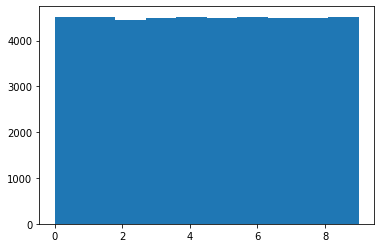

In [ ]:
#plot distribution of Training set
plt.hist(y_train)

## Define necessary functions and constants

In [ ]:
''' Clear any previous Tensorflow graph'''
K.clear_session()

#Define some useful constant variables
n_hidden = 20
n_neurons = 100
n_classes = len(np.unique(y_train))
n_epochs = 50
batch_size = 32
input_shape = X_train.shape[1:]
paramaters = {1: ['lecun_normal', 'sigmoid', 'adam', False, False], # [initializer, activation, optimizer, batch_norm, Dropout]
              2: ['lecun_normal', 'tanh', 'adam', False, False],
              3: ['glorot_normal', 'tanh', 'adam', False, False],
              4: ['he_normal', 'tanh', 'adam', False, False],
              5: ['he_normal', 'relu', 'adam', False, False],
              6: ['he_normal', 'elu', 'adam', False, False],
              7: ['he_normal', 'elu', 'adam', True, False],
              8: ['lecun_normal', 'sigmoid', 'adam', True, False],
              9: ['orthogonal', 'elu', 'adam', False, False],
              10: ['he_normal', 'elu', '1cycle', True, False],
              11: ['he_normal', 'elu', 'adam', True, True]
              }

In [ ]:
# Define a function to add hidden layer to the model
def add_layers(model, initializer, activation, bn, dropout):  # Dense > Batchnorm > Activation > Dropout
    for i in range(n_hidden):
        model.add(keras.layers.Dense(units=n_neurons, kernel_initializer=initializer, activation=None))  # Dense
        if bn:
            model.add(keras.layers.BatchNormalization())                                                 # Batch Normalization
        model.add(keras.layers.Activation(activation))                                                   # Activation
        if dropout:  
            keras.layers.Dropout(rate=0.1)                                                               # Dropout
         
    return model

## Create a model for different experiments

In [ ]:
# Get model parameters from dictionary
model_dict = {}
for i in range(1, 9):
    p = paramaters[i]
    initializer = p[0]; activation = p[1]; bn = p[3]; dropout = p[4]

    # Create the model
    model = keras.models.Sequential(name='DenseClassifier_' + np.str(i))
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model = add_layers(model= model, initializer=initializer, activation=activation, bn=bn, dropout=dropout)
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    model_dict['model_'+ str(i)] = model

## Train the different models

In [ ]:
%%time

history_dict = {}
wall_time_dict = {}

for i in range(1, 9):
    # Get the corresponding training parameters
    p = paramaters[i]

    #Print model parameter
    print('Model_{} : [ initializer = {}, activation = {}, optimizer = {}, batch_norm = {}, Dropout = {} ]'.format(i, p[0], p[1], p[2], p[3], p[4]) )

    # Retrieve a model from the model dictionary
    model = model_dict['model_'+ str(i)] 
    model.summary()

    # Model optimizer
    if p[2] == 'adam':
      optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    elif p[2] == '1cycle' :
      #optimizer = keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
      # STILL NEED TO BE COMPLETED

    # Train the model
    ''' Compile the model '''
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy']
                )

    ''' Create early stopping callback '''
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=0, 
                                                    patience=10, 
                                                    verbose=1, 
                                                    mode='auto',
                                                    restore_best_weights=True
                                                    )

    ''' initialize timer for training '''
    start_time = timeit.default_timer()

    ''' Fit the model '''
    history = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping_cb]
                    )

    ''' Compute the wall time '''
    wall_time = timeit.default_timer() - start_time

    ''' Save each model history and trining time into a dictionary'''
    history_dict['history_' + str(i)] = history
    wall_time_dict['wall_time_' + str(i)] = wall_time
    print('\n\n')


Model_1 : [ initializer = lecun_normal, activation = sigmoid, optimizer = adam, batch_norm = False, Dropout = False ]
Model: "DenseClassifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100   

## Evaluate the different models on test data

In [ ]:
print('\n--Experiment--  --NumOfEpochs--  --Training time--  --Test loss--  --Test accuracy--')
print()
result_dict = {}
for i in range(1, 9):
    ''' Get current history from dictionary '''
    history = history_dict['history_'+ str(i)]

    ''' Get the number of epochs from history '''
    numOfEpochs = len(history.history['loss'])

    ''' Retrieve a model from the model dictionary '''
    model = model_dict['model_'+ str(i)] 

    ''' Evaluate the model '''
    result = model.evaluate(X_test, y_test, verbose=0)
    result_dict['result_'+ str(i)] = result
    print('\n    Model_{}           {}            {:.4f}            {:.4f}           {:.4f}'
          .format(i, numOfEpochs, wall_time_dict['wall_time_' + str(i)], result_dict['result_'+ str(i)][0], result_dict['result_'+ str(i)][1]))



--Experiment--  --NumOfEpochs--  --Training time--  --Test loss--  --Test accuracy--


    Model_1           17            186.9684            2.3026           0.1000

    Model_2           20            217.0314            2.3039           0.1000

    Model_3           17            198.4428            2.3063           0.1000

    Model_4           12            140.3651            2.3076           0.1000

    Model_5           24            286.6756            1.9227           0.2482

    Model_6           25            311.8324            1.5818           0.4259

    Model_7           36            761.2532            1.4293           0.5115

    Model_8           31            641.9343            1.4768           0.4737


## Plot Learning Curves


Model_1


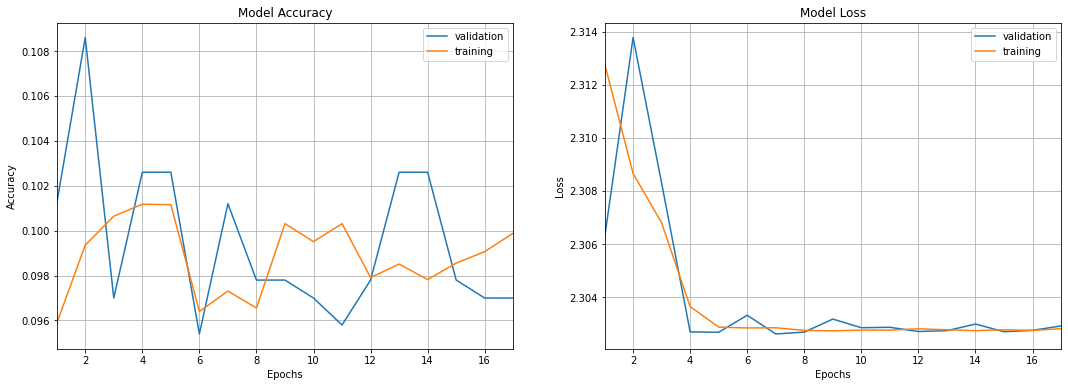




Model_2


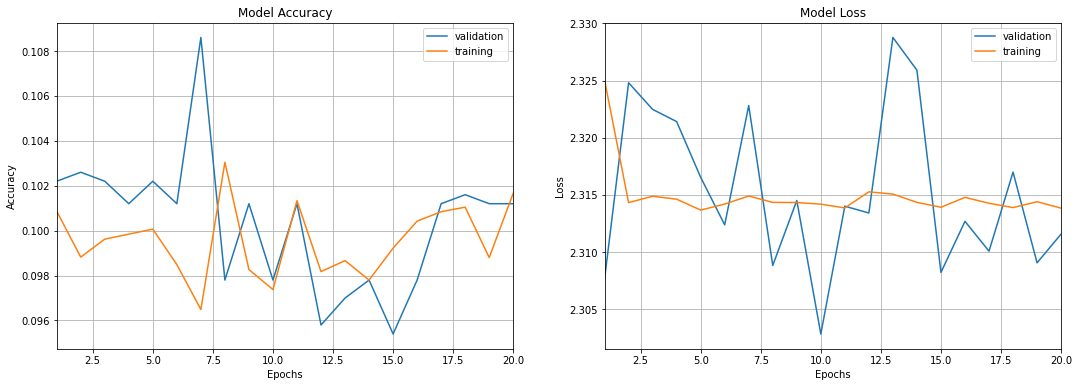




Model_3


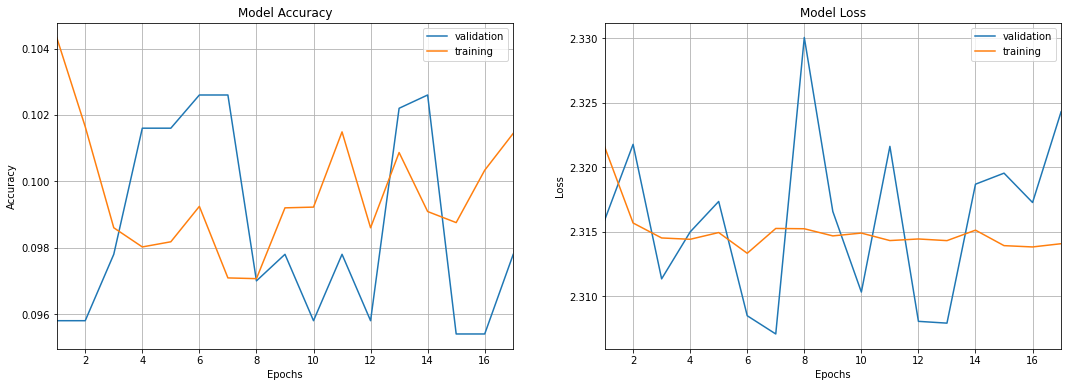




Model_4


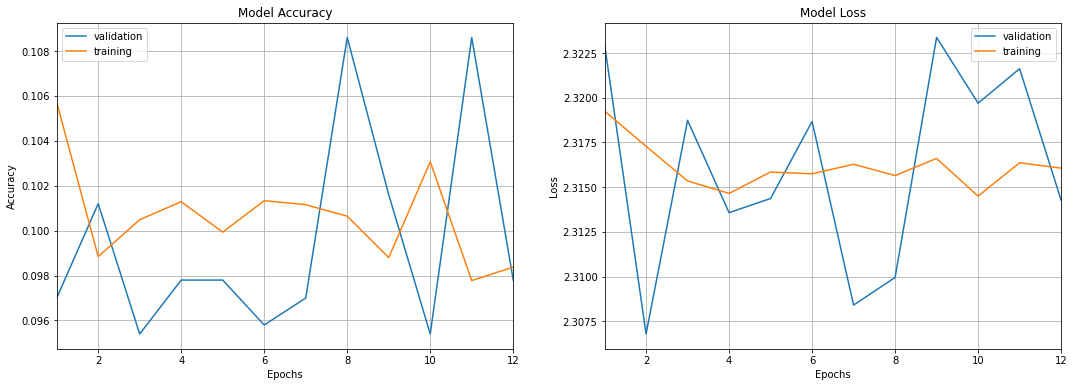




Model_5


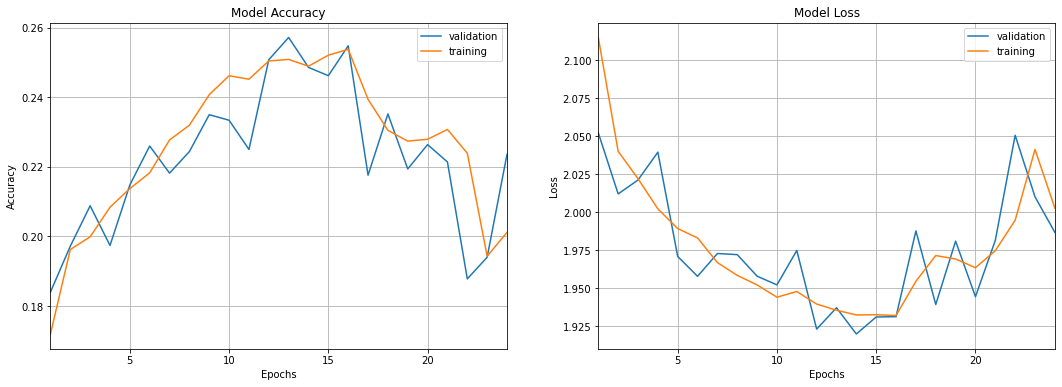




Model_6


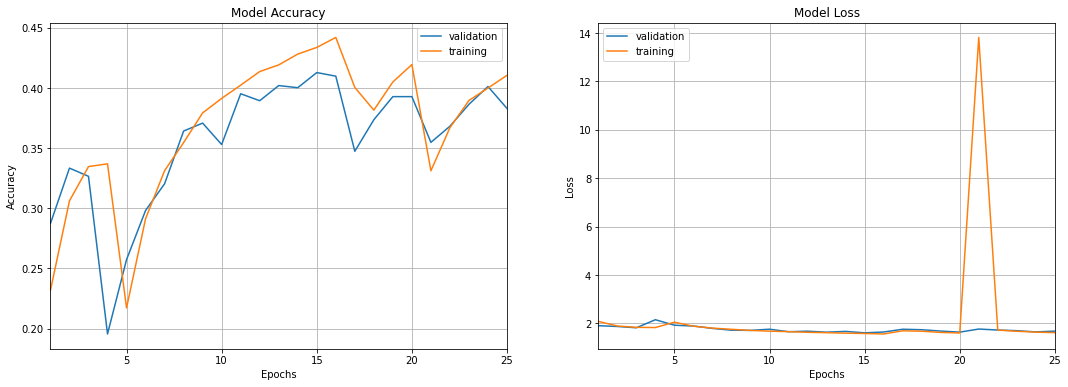




Model_7


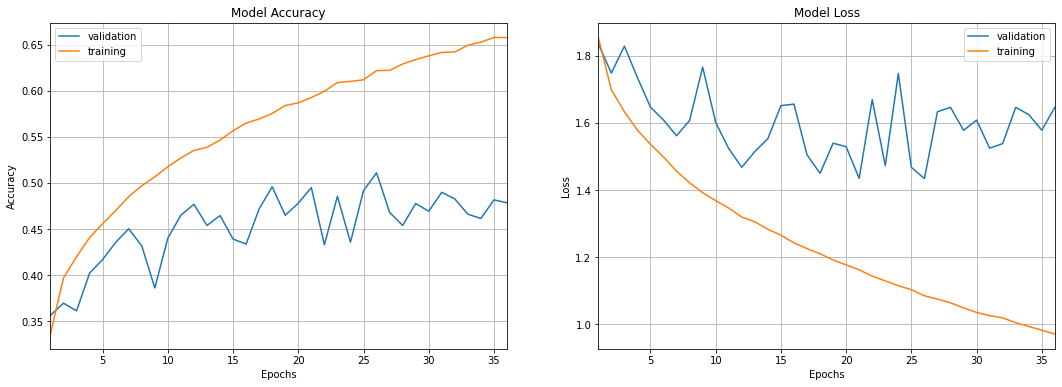




Model_8


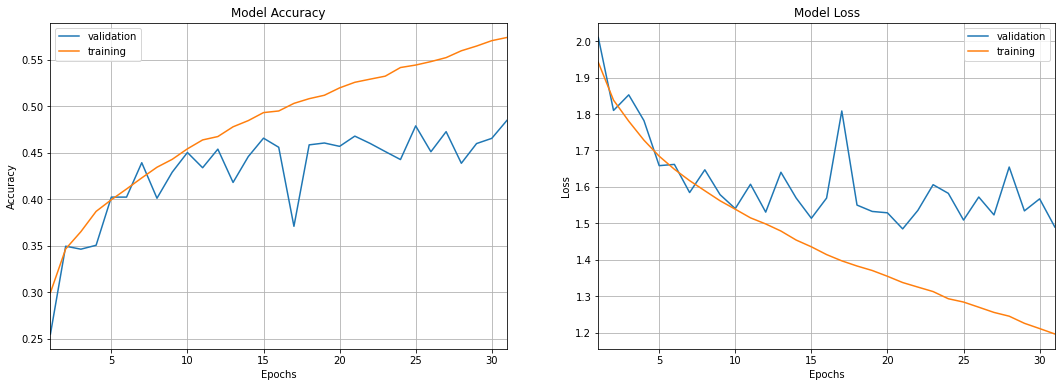

In [ ]:
for i in range(1, 9):
    print('\nModel_'+ str(i))

    # Get current history from dictionary
    history = history_dict['history_'+ str(i)]

    # Get the number pf epochs from history
    numOfEpochs = len(history.history['loss'])

    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy")

    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss")

    plt.show()
    print('\n')

## Save the Model on File

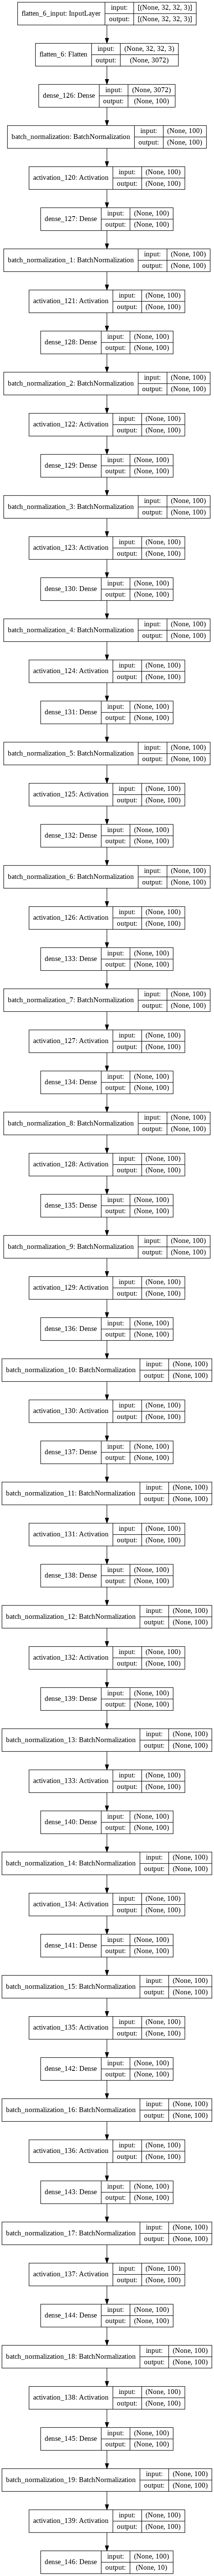

In [ ]:
keras.utils.plot_model(model_dict['model_7'], to_file='cifar10_model_7.png', show_shapes=True)